# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - контролировать добросовестность кассиров при продаже алкоголя.
 
Требуется построить модель, которая по фотографии определит приблизительный возраст человека. 

<font color='green'>Цель</font>

Определить возраст по фотографии.

<font color='green'>Задачи</font>

- исследовать данные;
- добавить аугментации при необходимости;
- достигнуть показателя метрики 'mae' < 8.


<font color='green'>Файлы</font>

- `labels.csv` - данные о возрасте;
- `final_files` - папка с фотографиями.


<font color='green'>Целевой признак</font>

- `real_age` — возраст

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

## Исследовательский анализ данных

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
features, target = next(train_gen_flow)
print(labels.shape)
print(features.shape)

(7591, 2)
(32, 224, 224, 3)


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


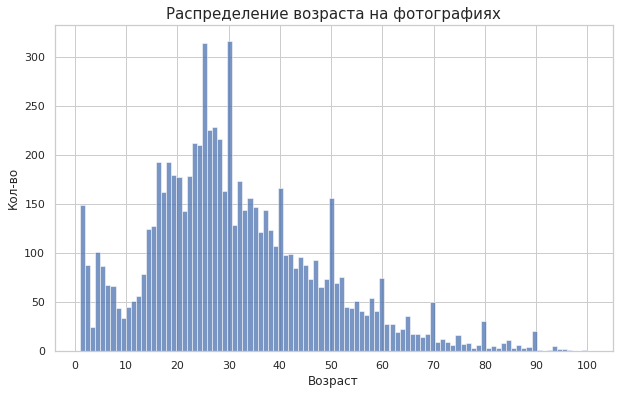

In [6]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=100)
plt.ylabel('Кол-во')
plt.xlabel('Возраст')
plt.title('Распределение возраста на фотографиях', fontsize=15)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.draw()

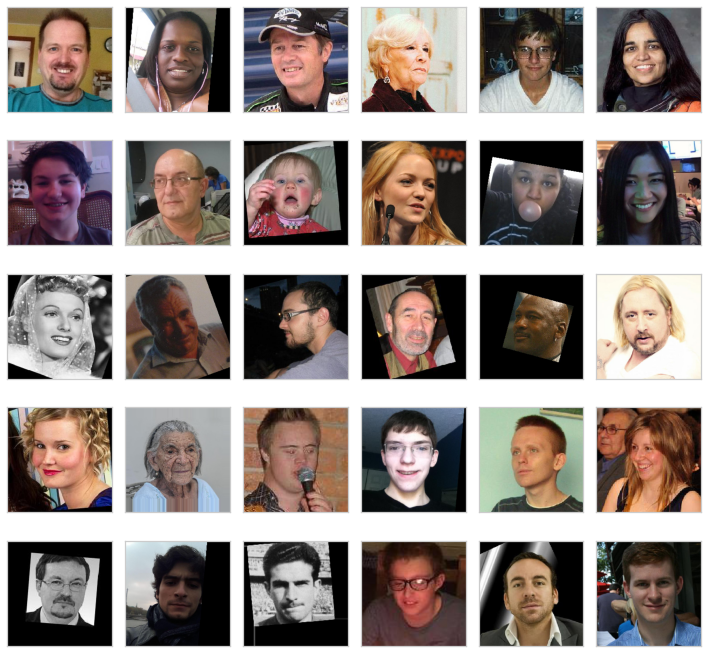

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(30):
    fig.add_subplot(5, 6, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout() 

**Вывод**

В нашем расоряжении 7591 трехканальных фото размером 224*224. 
Распределение имеет локальные максимумы, привязанные в том числе к круглым значениям: 30, 40, 50, 60 и т.д.
 - средний возраст - 31 год
 - min - 1 год
 - max - 100 лет

Выявленные признаки фото:
- качество изображений разное;
- есть цветные и черно-белые фото;
- присутствуют фото анфас, пол-оборота, профиль;
- присутствуют фото c изображением нескольких людей;
- есть фото без людей;
- есть фото с фактически меньшими размерами c заполнение  оставшегося пространства черным фоном;
- есть фото в полный рост, лицо не в центре кадра.


Возможные проблемы при обучении модели:

- достаточно маленькая выборка;
- неоднозначность некоторых фото (2 человека, без людей и т.п.);
- ограниченность кол-ва фото людей старших возрастов;

Возможные варианты решения проблем:

- применить обрезку изображений;
- увеличить кол-во черно-белых фото;
- установить единую яркость / изменить яркость у части изображений;
- повернуть часть изображений на угол менее 90%.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

def load_train(path):

	datagen_train = ImageDataGenerator(rescale=1./255., 
					validation_split=0.2,
					width_shift_range=[-0.1, 0, +0.1],
					zoom_range = 0.2)


	train_datagen_flow = datagen_train.flow_from_dataframe(
						
						dataframe = pd.read_csv('/datasets/faces/labels.csv'),
        					directory = '/datasets/faces/final_files/',
						x_col='file_name',
        					y_col='real_age',
    						target_size=(224, 224),
    						batch_size=16,
    						class_mode='raw',
   						subset='training',
    						seed=12345)

	return train_datagen_flow


def load_test(path):

	datagen_test = ImageDataGenerator(rescale=1./255., validation_split=0.2)

	labels = pd.read_csv('/datasets/faces/labels.csv')
	test_datagen_flow = datagen_test.flow_from_dataframe(
						dataframe = pd.read_csv('/datasets/faces/labels.csv'),
    						directory = '/datasets/faces/final_files/',
						x_col='file_name',
        					y_col='real_age',
						target_size=(224, 224),
    						batch_size=16,
    						class_mode='raw',
   						subset='validation',
    						seed=12345)

	return test_datagen_flow
 

def create_model(input_shape):
	optimizer = Adam(learning_rate = 0.0005)
	backbone= ResNet50(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet') 
	model = Sequential()
	model.add(backbone)
	model.add(GlobalAveragePooling2D())
	model.add(Dense(1, activation='relu')) 
	model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

	return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):

 		    
	model.fit(train_data, 
		validation_data=test_data,
		batch_size=batch_size, 
		epochs=epochs,
		steps_per_epoch=steps_per_epoch,
		validation_steps=validation_steps,
		verbose=2, shuffle=True)

	return model

```

```
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
    to  
  ...
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 380 steps, validate for 95 steps
Epoch 1/20
2022-12-02 07:40:04.522478: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-12-02 07:40:04.844690: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
380/380 - 105s - loss: 209.7695 - mae: 11.0595 - val_loss: 380.3292 - val_mae: 14.5259
Epoch 2/20
380/380 - 97s - loss: 148.3991 - mae: 9.3521 - val_loss: 226.0910 - val_mae: 11.4635
Epoch 3/20
380/380 - 96s - loss: 127.5893 - mae: 8.5883 - val_loss: 183.3279 - val_mae: 10.2845
Epoch 4/20
380/380 - 95s - loss: 112.5300 - mae: 8.1093 - val_loss: 115.0658 - val_mae: 8.2745
Epoch 5/20
380/380 - 97s - loss: 99.1647 - mae: 7.6101 - val_loss: 87.9423 - val_mae: 7.1431
Epoch 6/20
380/380 - 96s - loss: 86.5027 - mae: 7.0766 - val_loss: 100.5715 - val_mae: 7.9271
Epoch 7/20
380/380 - 97s - loss: 79.2890 - mae: 6.8170 - val_loss: 144.0816 - val_mae: 8.9769
Epoch 8/20
380/380 - 99s - loss: 77.1662 - mae: 6.7012 - val_loss: 98.5342 - val_mae: 7.6083
Epoch 9/20
380/380 - 98s - loss: 72.7538 - mae: 6.4803 - val_loss: 122.3207 - val_mae: 8.1974
Epoch 10/20
380/380 - 99s - loss: 62.7180 - mae: 6.0360 - val_loss: 82.3227 - val_mae: 6.8355
Epoch 11/20
380/380 - 99s - loss: 57.6979 - mae: 5.8678 - val_loss: 86.3309 - val_mae: 6.8530
Epoch 12/20
380/380 - 99s - loss: 55.8471 - mae: 5.6753 - val_loss: 99.8816 - val_mae: 7.3537
Epoch 13/20
380/380 - 98s - loss: 49.0716 - mae: 5.3786 - val_loss: 86.9672 - val_mae: 6.9240
Epoch 14/20
380/380 - 97s - loss: 47.4462 - mae: 5.3270 - val_loss: 104.3098 - val_mae: 7.5247
Epoch 15/20
380/380 - 99s - loss: 45.5632 - mae: 5.2200 - val_loss: 94.5273 - val_mae: 7.3911
Epoch 16/20
380/380 - 99s - loss: 39.9071 - mae: 4.8924 - val_loss: 101.7787 - val_mae: 7.6157
Epoch 17/20
380/380 - 98s - loss: 41.1518 - mae: 4.9562 - val_loss: 94.0405 - val_mae: 7.3471
Epoch 18/20
380/380 - 98s - loss: 35.6987 - mae: 4.5819 - val_loss: 108.0706 - val_mae: 7.6099
Epoch 19/20
380/380 - 98s - loss: 35.9686 - mae: 4.6361 - val_loss: 102.5052 - val_mae: 7.6941
Epoch 20/20
380/380 - 97s - loss: 31.0102 - mae: 4.3066 - val_loss: 80.5638 - val_mae: 6.7031
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
95/95 - 8s - loss: 80.5638 - mae: 6.7031
Test MAE: 6.7031

```

**Вывод**

В качестве основы для модели предсказания возраста использовали ResNet50. 

Величина MAE модели на тестовой выборке на 20-й эпохе составила 6.7031.

## Анализ обученной модели

Приемлемого качества нейронная сеть достигла к 10-й эпохе. 

Показатели метрики на 20 эпохе:
    
loss: 31.0102 - mae: 4.3066 - val_loss: 80.5638 - val_mae: 6.7031   

Параметры модели:
   - optimizers: Adam(learning_rate = 0.0005)
   - функция активации в выходном слое 'relu'
    
Аугментации:
   - width_shift_range=[-0.1, 0, +0.1]
   - zoom_range = 0.2
    
Время обучения: менее 30 минут

**Вывод**

В качестве основы для модели предсказания возраста использовалась предобученная модель ResNet50. 
Достигнутые показатели:
    
- train: loss: 31.0102 mae: 4.3066 
- test:    loss: 80.5638 mae: 6.7031   

Основными целями разработки модели были:
    
 1) анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
 
 2) контролировать добросовестность кассиров при продаже алкоголя.
    
Уровень 'mae' в 7 лет не обеспечит должного качества для цели №2, рекомендуется использовать модель только для цели №1. 